In [1]:
library(Seurat)
library(SeuratWrappers)
library(ggplot2)
library(scales)
library(STACAS)
library(grid)
library(gridExtra)
library(reshape2)
library(lisi)
library(BuenColors)
library(stringr)

Attaching SeuratObject

Loading required package: MASS



### Generate Figures (scVI results)

In [2]:
#load annotations
annot=read.csv("natgen_annots/umel_reorder.csv")

In [3]:
#load scVI coordinates
scvi_cells <- read.csv("ribas/UMEL/UMEL_orig.ident.csv")
scvi_dense <- read.csv("ribas/UMEL/UMEL_scvi_dense_pcs.csv")
scvi_dense_umap <- read.csv("ribas/UMEL/UMEL_scvi_dense_umap.csv")

scvi_dense_full<-cbind(scvi_dense_umap,annot[["X1"]],scvi_cells[['orig.ident']])
colnames(scvi_dense_full) <- c("X","X0","X1","annot",'orig.ident')

In [7]:
#plot celltypes in scVI coordinates
g<-ggplot(shuf(scvi_dense_full), aes(x=X0, y=X1,color=annot)) + ggtitle("Cell Type")+xlab("UMAP1")+ylab("UMAP2")+geom_point(size=.3) +theme_classic()+theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 9, override.aes = list(size=3)))
ggsave(g,file="UMEL_scvi_dense_celltypes.eps",device="eps")

Saving 6.67 x 6.67 in image



In [9]:
#plot sample origin in scVI coordinates
g<-ggplot(shuf(scvi_dense_full), aes(x=X0, y=X1,color=orig.ident)) + ggtitle("Sample Origin")+xlab("UMAP1")+ylab("UMAP2")+ geom_point(size=.3)+theme_classic() + theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 9, override.aes = list(size=3)))
ggsave(g,file="UMEL_scvi_dense_origin.eps",device="eps")

Saving 6.67 x 6.67 in image



In [11]:
#compute LISI scores
umap_coords=scvi_dense[c("X0","X1","X2","X3","X4","X5","X6","X7","X8","X9","X10","X11","X12","X13","X14","X15","X16","X17","X18","X19")]

labels <- scvi_cells["orig.ident"]
names(labels) <- c('celltype')

res <- compute_lisi(umap_coords, labels, c("celltype"))

mean(res[['celltype']])

[1] 1.226509

In [13]:
#plot LISI scores in scVI coordinates
g<-ggplot(scvi_dense_umap, aes(x=X0, y=X1,color=res[["celltype"]])) + 
  geom_point() + labs(colour = "LISI score") + ggtitle("Mean LISI score: 1.23")+theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(g,file="figures/UMEL_scvi_dense_LISI.eps",device="eps")

Saving 6.67 x 6.67 in image



### Load Data

In [14]:
UMEL_E12=readRDS('ribas/UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12_final_thresh/UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12_final_thresh_cb.rds')
UMEL_F1=readRDS('ribas/UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1_final_thresh/UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1_final_thresh_cb.rds')
UMEL_F12=readRDS('ribas/UMEL-CUUM1-SNRNA-5P-WI-PRIMARY-GEX-F12_final_thresh/UMEL-CUUM1-SNRNA-5P-WI-PRIMARY-GEX-F12_final_thresh_cb.rds')

In [17]:
NSCL_merged <- merge(UMEL_E12, 
                     y = c(UMEL_F1,UMEL_F12), add.cell.ids = c("UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12","UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1","UMEL-CUUM1-SNRNA-5P-WI-PRIMARY-GEX-F12"), project = "UMEL")

In [18]:
genes=read.csv("ribas/UMEL/UMEL_hvg_list.csv",header=FALSE)

In [19]:
mat<-as.data.frame(GetAssayData(object = NSCL_merged, slot = "counts"))

In [20]:
NSCL_merged=CreateSeuratObject(mat[unlist(genes),], project = "NSCL", assay = "RNA",meta.data = NSCL_merged@meta.data)

In [21]:
NSCL_merged.list <- SplitObject(NSCL_merged,split.by='orig.ident')

### Raw Control

In [ ]:
NSCL_merged <- NormalizeData(NSCL_merged)
NSCL_merged <- FindVariableFeatures(NSCL_merged)

In [ ]:
NSCL_merged <- ScaleData(NSCL_merged)
NSCL_merged <- RunPCA(NSCL_merged, features = NSCL_merged@assays$RNA@var.features, ndims.print = 1:5, nfeatures.print = 5)

In [ ]:
ndim=10
NSCL_merged <- RunUMAP(NSCL_merged, reduction = "pca", dims = 1:ndim, seed.use=123)

In [ ]:
DimPlot(NSCL_merged, group.by = c("patient"), ncol = 1, shuffle=TRUE)+theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 6, override.aes = list(size=5)))

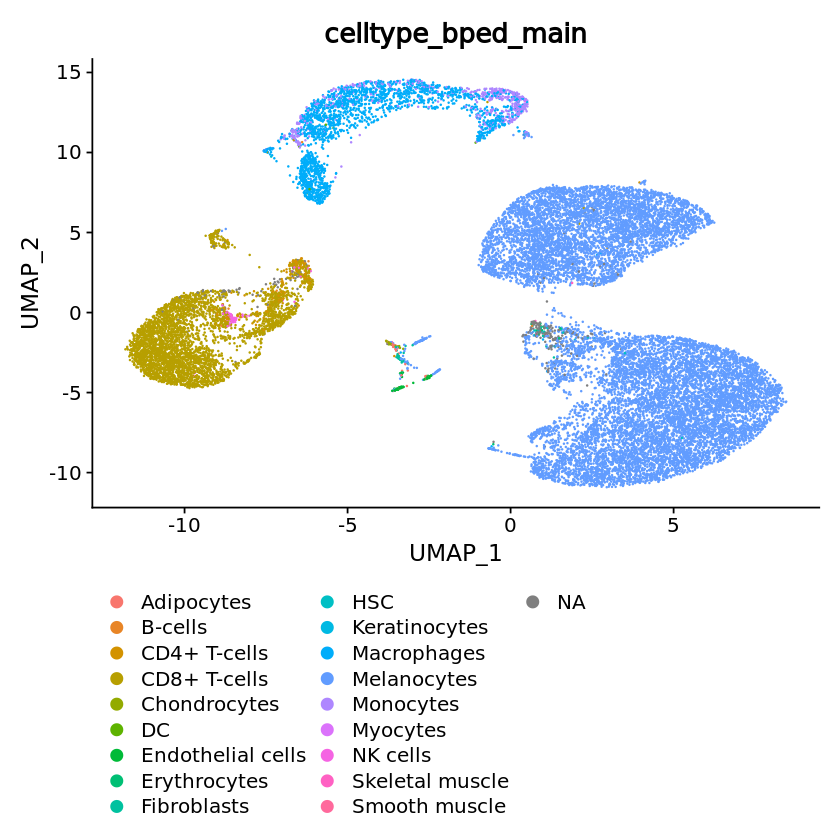

In [14]:
DimPlot(NSCL_merged, group.by = c("celltype_bped_main"), ncol = 1, shuffle=TRUE)+theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 9, override.aes = list(size=3)))

In [15]:
#compute PCs for computing LISI scores
pcs=prcomp(t(as.matrix(NSCL_merged@assays$RNA[c(1:8000)])),rank=20)

umap_coords=pcs$x

labels <- as.data.frame(NSCL_merged@meta.data$orig.ident)
names(labels) <- c('celltype')

res <- compute_lisi(umap_coords, labels, c("celltype"))

mean(res[['celltype']])

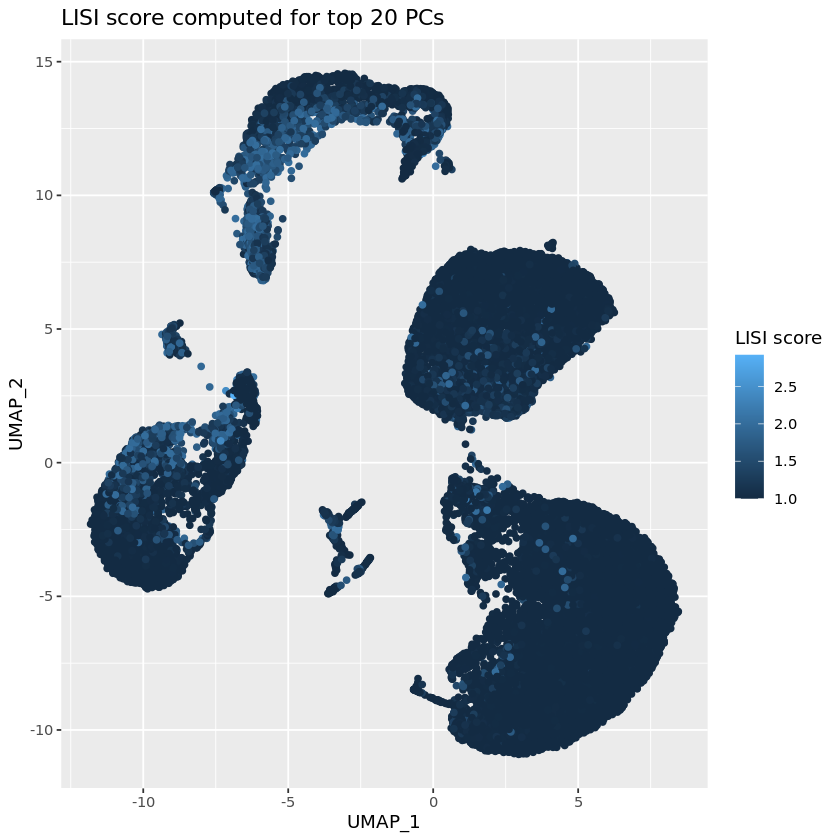

In [17]:
ggplot(as.data.frame(NSCL_merged[["umap"]]@cell.embeddings), aes(x=UMAP_1, y=UMAP_2,color=res[["celltype"]])) + 
  geom_point() + labs(colour = "LISI score") +ggtitle("LISI score computed for top 20 PCs")

In [1]:
NSCL_merged=readRDS("ribas/UMEL/UMEL_raw_Seurat.rds")
annot=read.csv("ribas/DEGs/UMEL_annotations")

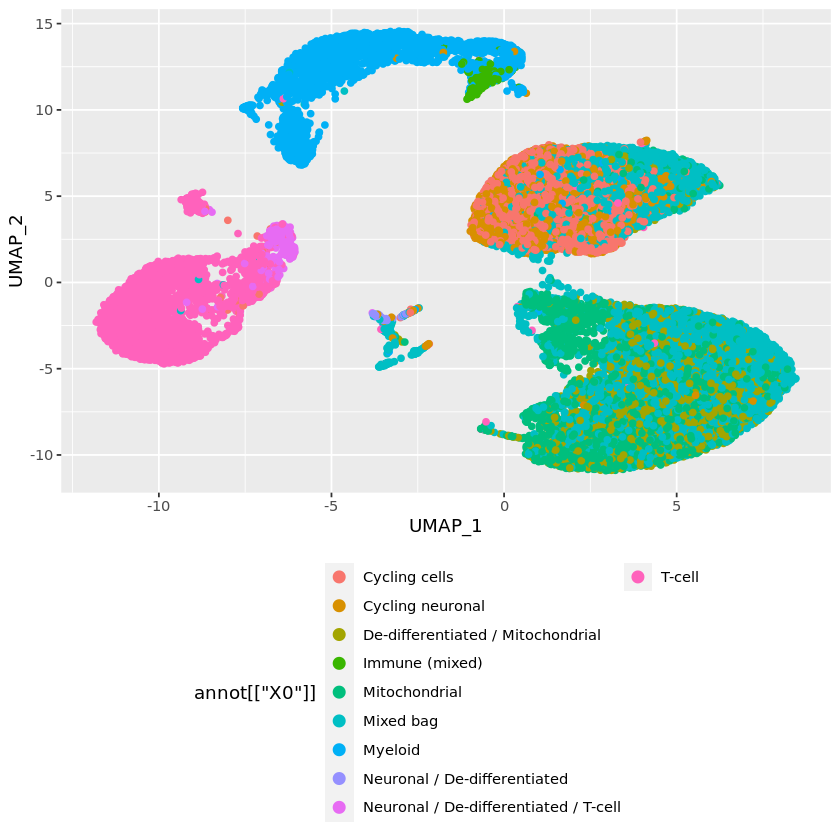

In [4]:
ggplot(as.data.frame(NSCL_merged[["umap"]]@cell.embeddings), aes(x=UMAP_1, y=UMAP_2,color=annot[["X0"]])) + 
  geom_point() + theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 9, override.aes = list(size=3)))


### Seurat Integration

In [22]:
#prepare to run standard integration using Seurat

NSCL_merged.list <- lapply(X = NSCL_merged.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

In [23]:
features <- SelectIntegrationFeatures(object.list = NSCL_merged.list)

In [24]:
immune.anchors <- FindIntegrationAnchors(object.list = NSCL_merged.list, anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12954 anchors

Filtering anchors

	Retained 3558 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17023 anchors

Filtering anchors

	Retained 3542 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13826 anchors

Filtering anchors

	Retained 1219 anchors



In [25]:
# this command creates an 'integrated' data assay
immune.combined <- IntegrateData(anchorset = immune.anchors)

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 into 1 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [26]:
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindClusters(immune.combined, resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:33:34 UMAP embedding parameters a = 0.9922 b = 1.112

20:33:34 Read 21977 rows and found 30 numeric columns

20:33:34 Using Annoy for neighbor search, n_neighbors = 30

20:33:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:33:36 Writing NN index file to temp file /tmp/Rtmp9TDQQe/file35ba65fe3a42

20:33:36 Searching Annoy index using 1 thread, search_k = 3000

20:33:42 Annoy recall = 100%

20:33:42 Commencing smooth kNN distance calibration using 1 thread

20:33:43 Initializing fr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21977
Number of edges: 771193

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9092
Number of communities: 17
Elapsed time: 3 seconds


In [31]:
#compute PCs on Seurat integrated object

pcs=prcomp(t(as.matrix(immune.combined$integrated[c(1:2000)])),rank=20)

#evaluate batch effect using lisi score

umap_coords=pcs$x

labels <- as.data.frame(NSCL_merged@meta.data$orig.ident)
names(labels) <- c('celltype')

res <- compute_lisi(umap_coords, labels, c("celltype"))

mean(res[['celltype']])

[1] 1.233328

In [28]:
#generate figures for Seurat

seurat_dense_full<-cbind(immune.combined[["umap"]]@cell.embeddings,annot[["X1"]],immune.combined$patient)
colnames(seurat_dense_full) <- c("X0","X1","annot",'orig.ident')

g<-ggplot(shuf(as.data.frame(seurat_dense_full)), aes(x=as.double(X0), y=as.double(X1),color=annot)) + ggtitle("Cell Type")+xlab("UMAP1")+ylab("UMAP2")+geom_point(size=.3) +theme_classic()+theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 9, override.aes = list(size=3)))
ggsave(g,file="UMEL_seuratCCA_celltypes.eps",device="eps")

g<-ggplot(shuf(as.data.frame(seurat_dense_full)), aes(x=as.double(X0), y=as.double(X1),color=orig.ident)) + ggtitle("Sample Origin")+xlab("UMAP1")+ylab("UMAP2")+ geom_point(size=.3)+theme_classic() + theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 9, override.aes = list(size=3)))
ggsave(g,file="UMEL_seuratCCA_origin.eps",device="eps")

g<-ggplot(as.data.frame(immune.combined[["umap"]]@cell.embeddings), aes(x=UMAP_1, y=UMAP_2,color=res[["celltype"]])) + 
  geom_point() + labs(colour = "LISI score") +ggtitle("Mean LISI Score: 1.23")+theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(g,file="UMEL_seuratCCA_LISI.eps",device="eps")

Saving 6.67 x 6.67 in image



### STACAS

In [19]:
#parepare to run STACAS integration (below steps follow standard processing steps)

var.genes.n <- 800
var.genes.integrated.n <- 500

for (i in 1:length(NSCL_merged.list)) {
    NSCL_merged.list[[i]] <- NormalizeData(NSCL_merged.list[[i]], verbose = FALSE)
    
    NSCL_merged.list[[i]] <- FindVariableFeatures(NSCL_merged.list[[i]], selection.method = "vst", 
        nfeatures = var.genes.n*2, verbose = FALSE)
    
    NSCL_merged.list[[i]]@assays$RNA@var.features <- head( NSCL_merged.list[[i]]@assays$RNA@var.features, var.genes.n)
}

In [20]:
ndim=10
ref.anchors <- FindAnchors.STACAS(NSCL_merged.list, dims=1:ndim, anchor.features=var.genes.integrated.n)

Computing 500 integration features

Preparing PCA embeddings for objects...



 1/3 2/3 3/3


Computing within dataset neighborhoods

Finding all pairwise anchors

Finding neighborhoods

Finding anchors

	Found 1489 anchors

Finding neighborhoods

Finding anchors

	Found 2473 anchors

Finding neighborhoods

Finding anchors

	Found 433 anchors



In [21]:
names <- names(NSCL_merged.list)

plots <- PlotAnchors.STACAS(ref.anchors, obj.names=names)

g.cols <- 2
g.rows <- as.integer((length(plots)+2)/g.cols)
g <- do.call("arrangeGrob", c(plots, ncol=g.cols, nrow=g.rows))

Picking joint bandwidth of 0.0218

Picking joint bandwidth of 0.0371

Picking joint bandwidth of 0.0345



In [23]:
ref.anchors.filtered <- FilterAnchors.STACAS(ref.anchors)

Filter anchors using distance threshold t=0.860



In [24]:
#Before
anchor.stats.before <- table(ref.anchors@anchors[,c("dataset1","dataset2")])

#After
anchor.stats.after <- table(ref.anchors.filtered@anchors[,c("dataset1","dataset2")])

rownames(anchor.stats.before) <- names(NSCL_merged.list)
colnames(anchor.stats.before) <- names(NSCL_merged.list)
rownames(anchor.stats.after) <- names(NSCL_merged.list)
colnames(anchor.stats.after) <- names(NSCL_merged.list)
anchor.stats.before

                                        dataset2
dataset1                                 UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12                                      0
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1                                    1489
  UMEL-CUUM1-SNRNA-5P-WI-PRIMARY-GEX-F12                                   2473
                                        dataset2
dataset1                                 UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12                                  1489
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1                                      0
  UMEL-CUUM1-SNRNA-5P-WI-PRIMARY-GEX-F12                                   433
                                        dataset2
dataset1                                 UMEL-CUUM1-SNRNA-5P-WI-PRIMARY-GEX-F12
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12                                   2473
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1                  

In [25]:
anchor.stats.after

                                        dataset2
dataset1                                 UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12                                      0
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1                                    1191
  UMEL-CUUM1-SNRNA-5P-WI-PRIMARY-GEX-F12                                    835
                                        dataset2
dataset1                                 UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12                                  1191
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1                                      0
  UMEL-CUUM1-SNRNA-5P-WI-PRIMARY-GEX-F12                                   187
                                        dataset2
dataset1                                 UMEL-CUUM1-SNRNA-5P-WI-PRIMARY-GEX-F12
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-E12                                    835
  UMEL-CUUM1-SCRNA-5P-NA-PRIMARY-GEX-F1                  

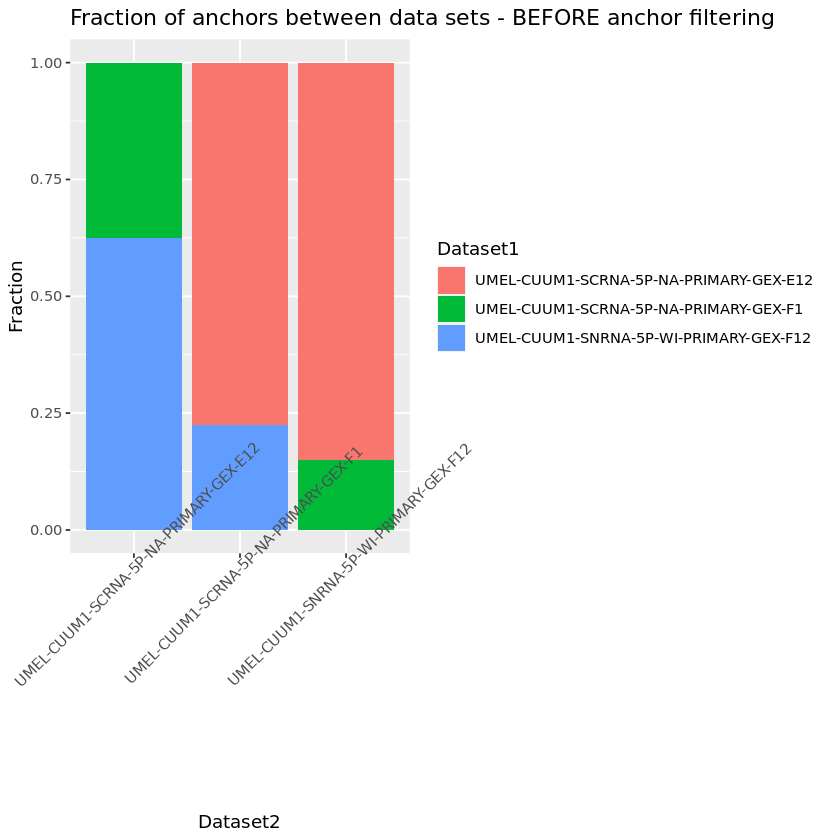

In [26]:
anchor.stats.before.norm <- apply(anchor.stats.before, 1, function(x) {x/sum(x)})
toplot <- melt(anchor.stats.before.norm, varnames=c("Dataset1","Dataset2"), value.name = "Fraction")
ggplot(toplot, aes(fill=Dataset1, y=Fraction, x=Dataset2)) + 
    geom_bar(position="stack", stat="identity") +
  theme(axis.text.x = element_text(angle = 45)) +
    ggtitle("Fraction of anchors between data sets - BEFORE anchor filtering")

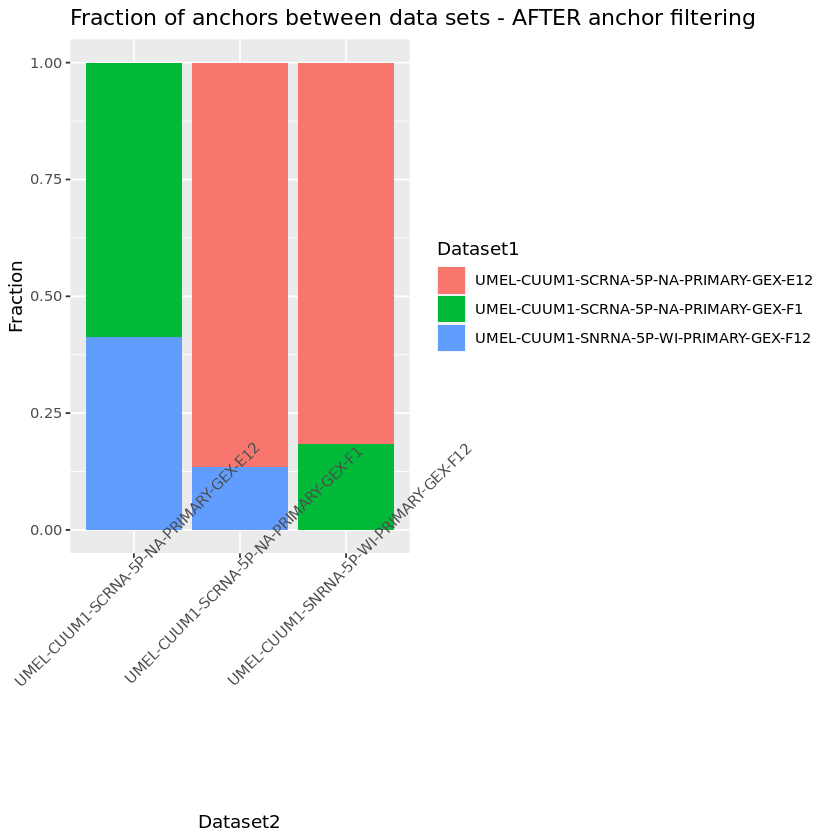

In [27]:
anchor.stats.after.norm <- apply(anchor.stats.after, 1, function(x) {x/sum(x)})
toplot <- melt(anchor.stats.after.norm, varnames=c("Dataset1","Dataset2"), value.name = "Fraction")
ggplot(toplot, aes(fill=Dataset1, y=Fraction, x=Dataset2)) + 
    geom_bar(position="stack", stat="identity") +
  theme(axis.text.x = element_text(angle = 45)) +
    ggtitle("Fraction of anchors between data sets - AFTER anchor filtering")

In [28]:
all.genes <- row.names(NSCL_merged.list[[1]])
for (i in 2:length(NSCL_merged.list)) {
   all.genes <- intersect(all.genes, row.names(NSCL_merged.list[[i]]))
}

mySampleTree <- SampleTree.STACAS(ref.anchors.filtered)
print(mySampleTree)

     [,1] [,2]
[1,]   -1   -2
[2,]    1   -3


In [29]:
ref.integrated <- IntegrateData(anchorset=ref.anchors.filtered, dims=1:ndim, features.to.integrate=all.genes,
                                sample.tree=mySampleTree, preserve.order=T)

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 into 1 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [30]:
ndim=15
length(ref.integrated@assays$integrated@var.features)

ref.integrated <- ScaleData(ref.integrated, verbose = TRUE)
ref.integrated <- RunPCA(ref.integrated, features = ref.integrated@assays$integrated@var.features,
                         ndims.print = 1:5, nfeatures.print = 5)

ndim=10  #how many PCA components to retain

ref.integrated <- RunUMAP(ref.integrated, reduction = "pca", dims = 1:ndim, seed.use=123, n.neighbors = 30, min.dist=0.3)


[1] 500

Centering and scaling data matrix

PC_ 1 
Positive:  HLA-DPA1, HLA-DPB1, HLA-DQA1, C1QC, HLA-DRA 
Negative:  VIM, PMEL, S100A1, CITED1, SERPINF1 
PC_ 2 
Positive:  NPC2, FTH1, CST3, CD63, NME2 
Negative:  GZMK, CD8A, CD2, IL2RG, NKG7 
PC_ 3 
Positive:  GZMK, CD8A, NKG7, CD2, IL2RG 
Negative:  AC109466.1, AC008415.1, ANKRD30B, CCSER1, PCDH7 
PC_ 4 
Positive:  AC109466.1, PMEL, CLDN1, ANKRD30B, AC008415.1 
Negative:  IGFBP4, COL4A1, ADGRF5, ARHGAP29, PDGFRB 
PC_ 5 
Positive:  UBE2C, MKI67, TOP2A, KIFC1, NUSAP1 
Negative:  FTL, CD8A, GZMK, NKG7, RPS8 

02:38:53 UMAP embedding parameters a = 0.9922 b = 1.112

02:38:53 Read 21977 rows and found 10 numeric columns

02:38:53 Using Annoy for neighbor search, n_neighbors = 30

02:38:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

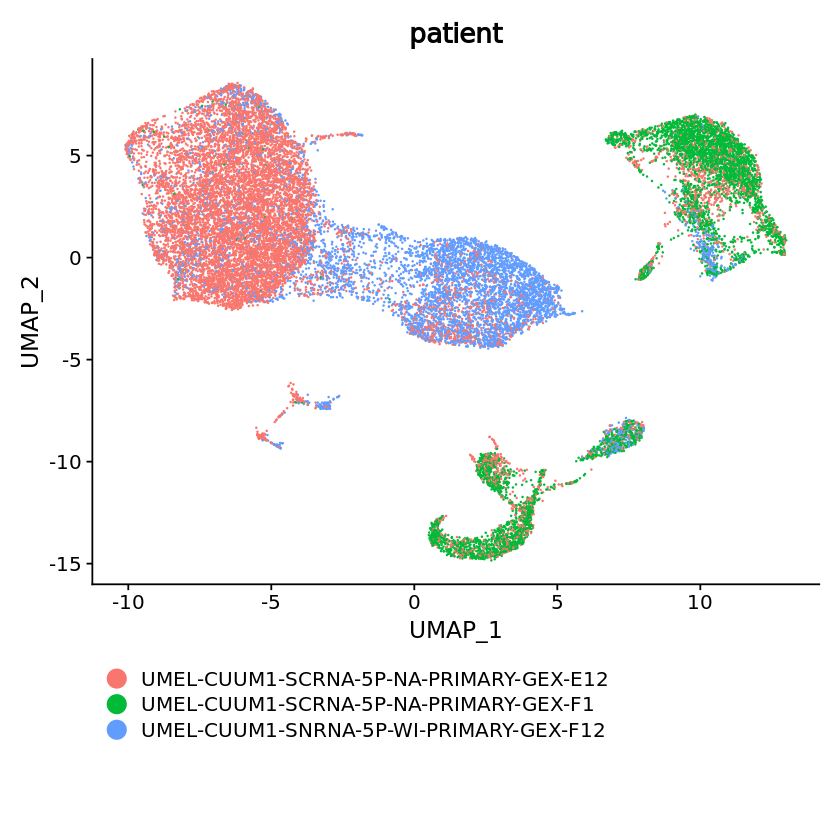

In [31]:
DimPlot(ref.integrated, reduction = "umap", group.by = "patient", shuffle=TRUE) +theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 6, override.aes = list(size=5)))


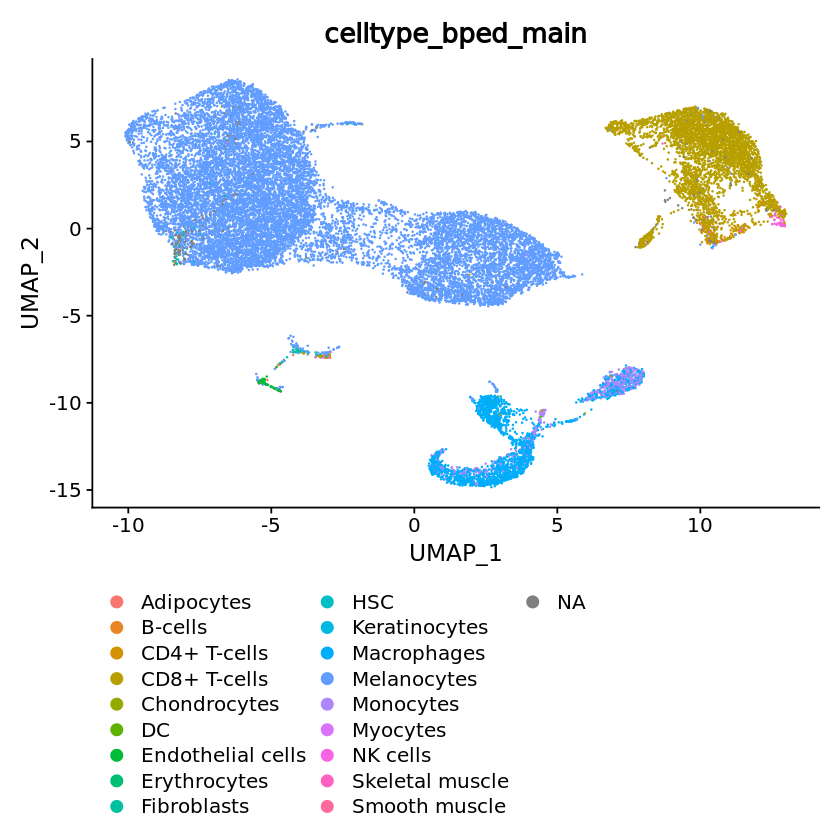

In [32]:
DimPlot(ref.integrated, reduction = "umap", group.by = "celltype_bped_main", shuffle=TRUE) +theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 9, override.aes = list(size=3)))


In [39]:
#compute PCs

pcs=prcomp(t(as.matrix(stacas@assays$integrated[c(1:8000)])),rank=20)

#evaluate batch effect using lisi score

umap_coords=pcs$x

labels <- as.data.frame(stacas@meta.data$orig.ident)
names(labels) <- c('celltype')

res <- compute_lisi(umap_coords, labels, c("celltype"))

mean(res[['celltype']])

In [42]:
#generate STACAS figures

g<-ggplot(as.data.frame(stacas[["umap"]]@cell.embeddings), aes(x=UMAP_1, y=UMAP_2,color=res[["celltype"]])) + 
  geom_point() + labs(colour = "LISI score") +ggtitle("Mean LISI Score: 1.23")+theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(g,file="figures/UMEL_stacas_LISI.eps",device="eps")

stacas_dense_full<-cbind(stacas[["umap"]]@cell.embeddings,annot[["X1"]],stacas$patient)
colnames(stacas_dense_full) <- c("X0","X1","annot",'orig.ident')

g<-ggplot(shuf(as.data.frame(stacas_dense_full)), aes(x=as.double(X0), y=as.double(X1),color=annot)) + ggtitle("Cell Type")+xlab("UMAP1")+ylab("UMAP2")+geom_point(size=.3) +theme_classic()+theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 9, override.aes = list(size=3)))
ggsave(g,file="UMEL_stacas_celltype.eps",device="eps")

g<-ggplot(shuf(as.data.frame(stacas_dense_full)), aes(x=as.double(X0), y=as.double(X1),color=orig.ident)) + ggtitle("Sample Origin")+xlab("UMAP1")+ylab("UMAP2")+geom_point(size=.3) +theme_classic()+theme(legend.position = "bottom")+guides(colour = guide_legend(nrow = 9, override.aes = list(size=3)))
ggsave(g,file="UMEL_stacas_origin.eps",device="eps")

Saving 6.67 x 6.67 in image

